# 04. Pytorch custom datasets

Getting your own dataset to pytorch and solving your problem set

and look at pytorch domain libaries depending on what your working on.

# 0. Importing Pytorch and setup device agnostic code

In [2]:
# import pytorch
import torch
torch.__version__

'2.4.0+cu124'

In [3]:
# device agnostic code
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# check gpu if available
!nvidia-smi

Wed Sep 11 14:23:57 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8             N/A / ERR!  |       0MiB /   4096MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get data

our dataset is a subset of food101 dataset, which is only 3 classes and only 10% of the images.



In [6]:
import requests
import zipfile
from pathlib import Path

# setup path to a data folder
data_path = Path("data/")
image_path = data_path / 'pizza_steak_sushi'

# if the image folder doesn't exist, download and prepare it...
if image_path.is_dir():
    print(f'{image_path} directory sudah ada, skipping download')
else:
    print(f'{image_path} tidak ada, mulai download')
    image_path.mkdir(parents=True, exist_ok=True)
    
# download the dataset from mrdbourke github
with open(data_path / 'pizza_steak_sushi.zip', mode="wb") as f:
    requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print('Downloading dataset')
    f.write(requests.content)
    
# unzip dataset
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping dataset')
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory sudah ada, skipping download
Unzipping dataset


## 2. Data preparation and data exploration

In [7]:
import os 
from helper_functions import walk_through_dir

In [8]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


### 2.1 Visualizing random images

tulis code untuk:
1. get all image path
2. pick a random image using python random
3. get image class name using `pathlib.Path.parent.stem`
4. open the image using python PIL(pillow)
5. show the image and print metadata

Random Image Path: data\pizza_steak_sushi\test\pizza\344397.jpg
Image Class: pizza
Image Height: 342
Image Width: 512


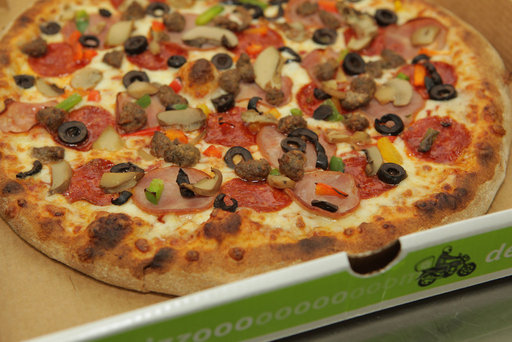

In [21]:
import random
from PIL import Image

# set seed
# random.seed(42)

# 1. get all image path
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. pick a random image path
random_image_path = random.choice(image_path_list)

# 3. get the image class from pathname
image_class =  random_image_path.parent.stem

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random Image Path: {random_image_path}')
print(f'Image Class: {image_class}')
print(f'Image Height: {img.height}')
print(f'Image Width: {img.width}')
img

In [ ]:
# try to visualize image with matplotlib
